<a href="https://colab.research.google.com/github/ADA-SITE-JML/azsl_dataloader/blob/main/AzSL_DataLoader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, I took out the feature extractor (a pre-trained model) from the Data Loader and added it into the Encoder. The name of the notebook also holds this: *_TRansferLEarningInENCoder

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import sklearn.utils
from sklearn.model_selection import train_test_split

In "Local"  option, the notebook shall connect to the local machine (where the  dataset is supposed to be). To connect to the CeDAR's environment run the following to start Jupyter with access:

```
jupyter notebook \
>   --NotebookApp.allow_origin='https://colab.research.google.com' \
>   --port=8888 \
>   --NotebookApp.port_retries=0
```
Then select "Connect to a local runtime" and put the link of notebook environment (from the console)



In [28]:
class Config:
    debug = False
    env = 'Prod' # Dev (User's GoogleDrive), Prod (AzSL GoogleDrive) or Local (local machine)
    csv_path = ''
    seed = 44
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    # device = 'tpu' # uncomment to switch to TPU usage

    # All 3 Video processing APIs implemented. Use the one that corresponds to your code
    video_processing_tool = 'TorchVision' # OpenCV, VidGear or TorchVision

    # To have a fixed frame size
    max_frames = 64
    # The maximum size of the output. This and previous parameters are considered
    # for training with the RNN and Transformer networks.
    max_words_in_sentence = 10

    video_size = 600


    drive_folder = '/home/....' # path for the local folder
    if (env == 'Dev'):
      drive_folder = '/content/drive/MyDrive/SLR_test' # path to your GoogleDrive folder
    elif (env == 'Prod'):
      drive_folder = '/content/drive/MyDrive/SLR/Data/Datasets/AzSLD' # path to the shared GoogleDrive folder

    train_csv_path = drive_folder+'/sentences.csv' # where the sentences and glosses are kept
    camera_source = 'Cam1' # Cam1 - side-top, Cam2 - front
    keep_hands_only = True # If true, will keep only frames with hands
    feature_type = 'no' # 'no' (frames only), 'i3d' # or 'squeezenet'

    BATCH_SIZE = 128 # updated before the training

def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)

config = Config()
seed_everything(config.seed)

print('Running on',config.device)

if torch.cuda.is_available():
    print('GPU number:',torch.cuda.device_count())

Running on cuda:0
GPU number: 1


This is the TPU configuration. Since it requies some preparation, it is separated from the pre-config code.

In [3]:
if (config.device == 'tpu'):
  !pip install cloud-tpu-client==0.10 torch==2.0.0 torchvision==0.15.1 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp39-cp39-linux_x86_64.whl

  import torch_xla
  import torch_xla.core.xla_model as xm


  dev = xm.xla_device()
  t1 = torch.ones(3, 3, device = dev)
  print(t1)
  config.device = dev

In [4]:
if (config.env != 'Local'):
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import sys
import subprocess

def pip_install(package):
  subprocess.check_call([sys.executable, '-m', 'pip', 'install',package])

In [6]:
pip_install('mediapipe')

# https://github.com/jbohnslav/opencv_transforms
pip_install('opencv_transforms')

if config.video_processing_tool == 'VidGear':
  pip_install('vidgear[core]')

In [7]:
# The video data could be provided as fames or features (i3d or pretrained model)
# The code is take from here: https://colab.research.google.com/drive/1LKoytZmNxtC-EuCp7pHDM6sFvK1XdwlW
if config.feature_type == 'i3d':
  # For I3D features
  !git clone https://github.com/v-iashin/video_features.git
  !pip install omegaconf==2.0.6

  %cd video_features

  from models.i3d.extract_i3d import ExtractI3D
  from models.raft.raft_src.raft import RAFT, InputPadder
  from utils.utils import build_cfg_path
  from omegaconf import OmegaConf

  # Load and patch the config
  args = OmegaConf.load(build_cfg_path(config.feature_type))
  # args.show_pred = True
  # args.stack_size = 24
  # args.step_size = 24
  # args.extraction_fps = 30
  args.flow_type = 'raft' # 'pwc' is not supported on Google Colab (cupy version mismatch)
  # args.streams = 'flow'

  # Load the model
  extractor = ExtractI3D(args)
elif config.feature_type == 'squeezenet':
  from torchvision.models import squeezenet1_1
  from torchvision.models.feature_extraction import create_feature_extractor

  model = squeezenet1_1(pretrained=True).to(config.device)
  return_nodes = {
        'features.12.cat': 'layer12'
        }
  pretrained_model = create_feature_extractor(model, return_nodes=return_nodes).to(config.device)
  pretrained_model.eval()

def frame_to_feats(pretrained_model, frames):
  features = pretrained_model(frames.squeeze())['layer12'].to(device=config.device)
  feat_shape = features.shape
  print('Squeezenet shape',feat_shape)
  feat_flat =  torch.reshape(features,(feat_shape[0],feat_shape[1]*feat_shape[2]*feat_shape[3])).to(device=config.device)
  return feat_flat

In [ ]:
train_set_size = 500

# read cvs file
sentences = pd.read_csv(config.train_csv_path)
sentences = sentences.iloc[:,:train_set_size]

# unique words
word_set = set(['SOS','EOS'])
sentences.iloc[:,2].str.lower().str.split().apply(word_set.update)
sorted_word_set = sorted(word_set)
print('Unique words',sorted_word_set)

# create word encoding
encodings = { k:v for v,k in enumerate(sorted_word_set)}
word_idx  = { v:k for k,v in encodings.items()}
print('Word encodings',encodings)
print('Words by index',word_idx)
torch.save(encodings,config.drive_folder+'/encodings.dict')
torch.save(word_idx,config.drive_folder+'/word_idx.dict')

# converts a sentence with zero padded encoding list
def get_sentence_encoded(sentence):
    encoded = [encodings[key] for key in ('SOS '+sentence+' EOS').split()]
    return  encoded + list([0]) * (config.max_words_in_sentence - len(encoded))

if config.debug:
  print(get_sentence_encoded('mən hansı sənəd vermək'))
  print(get_sentence_encoded('mən bakı yaşamaq'))

# generate (video file name, encoding list)
df = pd.DataFrame(columns=["id", "video_file","encoding"])

for index, row in sentences.iterrows():
    id = int(row[0])
    phrase = row[2].lower()
    encoded = get_sentence_encoded(phrase)

    dir = config.drive_folder + '/'+ str(id) + '/'+ config.camera_source
    # iterate over video folders
    for filename in os.listdir(dir):
        f = os.path.join(dir, filename)
        # checking if it is a file
        if os.path.isfile(f):
            entry = pd.DataFrame.from_dict({"id": id, "video_file": f, "encoding": [encoded]})
            df = pd.concat([df, entry], ignore_index = True)

if config.debug:
    print(df)

This is a sample code to visualize the frames (might be used for debugging and validation of the inference

In [12]:
import math

rows = int(math.sqrt(config.max_frames))
cols = config.max_frames//rows

def visualize_frames(frames):
  fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20,20))

  idx = 0
  for i in range(rows):
      for j in range(cols):
        axes[i, j].imshow(frames[0,idx,:,:,:].permute(1,2,0).cpu())
        idx += 1

TODO: Implement augmentation to the data

In [13]:
pip_install('pytorchvideo')

In [14]:
from torchvision import transforms

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    UniformTemporalSubsample,
    Permute,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    CenterCrop,
    RandomAdjustSharpness,
    Resize,
    ColorJitter,
    RandomHorizontalFlip
)

from torchvision.transforms._transforms_video import (
    CenterCropVideo,
    NormalizeVideo
)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


As an option, it is possible to keep frames with hands. This might be helpful when there are many 'idle' frames in the beginning or end.

The following code performs using the mediapipe's hand detection API. It might slow down the fetching process but if this step is necessary, then the data shall be saved first, and then loaded using a regular dataloader.

In [15]:
def get_video_frames(video_path,video_transform):
  video_data = None

  if config.video_processing_tool == 'OpenCV':
    video_data = cv2.VideoCapture(video_path)
  elif config.video_processing_tool == 'VidGear':
    video_data = CamGear(video_path).start()
  elif config.video_processing_tool == 'TorchVision':
    video_data, _, _ = torchvision.io.read_video(video_path, output_format="THWC")

  final_frames = video_data
  if config.keep_hands_only:
    final_frames = keep_frames_with_hands(video_data, crop_size=config.video_size).to(config.device)

  if video_transform:
    apply_trans = apply_video_transforms()
    hands_only = apply_trans(final_frames)

  if config.video_processing_tool == 'OpenCV':
    video_data.release()
  elif config.video_processing_tool == 'VidGear':
    video_data.stop()
  elif config.video_processing_tool == 'TorchVision':
    pass


  n,l,w,h = final_frames.shape

  # When frames are more than we need but not that much (just trim it from the start and end)
  if (n > config.max_frames) and (n < 2*config.max_frames):
    left = (n-config.max_frames)//2
    final_frames_new = final_frames[left:(n-left-1),:,:,:]
  # If we have much more frames than we need
  elif (n > config.max_frames):
    # Cut 5 frames from start/end and then skip every n-th
    slice_step = ((n-10)//config.max_frames+1)
    final_frames_new = final_frames[5:(n-5):slice_step,:,:,:]
  else:
    final_frames_new = final_frames

  n = final_frames_new.shape[0]

  # If we have less frames than we need
  if (n < config.max_frames):
    # fill with the last frames (usually 1)
    compliment_arr = hands_only[-(config.max_frames-n):,:,:,:]
    final_frames_new = torch.cat((final_frames_new,compliment_arr),0)

  return final_frames_new

def tensor2list(mdim_tensor):
  tensor_stack = []
  for i in range(mdim_tensor.shape[0]):
    tensor_stack.append(mdim_tensor[i])

  return tensor_stack

In [16]:
import cv2
import mediapipe as mp


# keeps only informative frames
def keep_frames_with_hands(video_data, crop_size: int = None,
                           mp_min_detection_confidence: float = 0.8, mp_min_tracking_confidence: float = 0.9):

  mpHands = mp.solutions.hands
  hands = mpHands.Hands(static_image_mode=True, max_num_hands=2,
                        min_detection_confidence=mp_min_detection_confidence, min_tracking_confidence=mp_min_tracking_confidence)

  if crop_size:
    video_arr = torch.zeros((0, 3, crop_size, crop_size)).to(config.device)
    transform = Compose([
      CenterCrop(crop_size),
      ])
  else:
    video_arr = torch.zeros((0, 3, 960, 1280)).to(config.device)

  ret = True
  frame = None

  for frame in video_data:
    hand_results = hands.process(frame.numpy())

    if hand_results.multi_hand_landmarks != None:
      if crop_size:
        frame_ext = torch.unsqueeze(transform(frame.permute(2, 0, 1)), dim=0).to(config.device)
      else:
        frame_ext = torch.unsqueeze(frame.permute(2, 0, 1), dim=0).to(config.device)

      video_arr = torch.cat((video_arr, frame_ext/255.0),0)


  return video_arr

The resize of the video frames done through the following transformations:

In [17]:
def apply_video_transforms(resize_size: int = config.video_size):
    video_transform=Compose([
        Resize(size=(resize_size, resize_size))
    ])

    return video_transform

In [24]:
if config.video_processing_tool == 'VidGear':
  from vidgear.gears import CamGear
import torchvision
from torchvision.models.feature_extraction import create_feature_extractor

class SLDataset(Dataset):

    def __init__(self, df, video_transform: bool = True):
        # shuffle and save
        self.df = sklearn.utils.shuffle(df)
        self.video_transform = video_transform

    def __getitem__(self, idx):
        if config.debug:
          print(f"Got item at index: {idx}")
        video_path = df.iloc[idx,1]

        encoding = torch.tensor(df.iloc[idx,2]).to(config.device)
        enc_shape = encoding.shape[0]

        if config.feature_type == 'i3d':
          feature_dict = extractor.extract(video_path)

          f_num, f_size = feature_dict['rgb'].shape
          REQ_FEATS = 5 # required number of features

          # Keep only REQ_FEATS features from each and apply zero padding if there are less than REQ_FEATS features
          feats_rgb = torch.from_numpy(feature_dict['rgb'])
          feats_flow = torch.from_numpy(feature_dict['flow'])

          # Trim extra features.
          # Trim shall be applied on each, since we need to have equal number of RGB and FLOW features.
          # Like for RGB and FLOW, 8 features each will make 16 features if we apply catenation first.
          # If we trimming after that to keep 10 features, eight of them will be about RGB, two - FLOW.
          if f_num > REQ_FEATS:
            feats_rgb  = feats_rgb[-(REQ_FEATS-f_num):,:]
            feats_flow = feats_flow[-(REQ_FEATS-f_num):,:]

          # Concatenate the features
          feats = torch.cat((feats_rgb,feats_flow),1)

          # Apply zero padding if needed.
          # Zero padding needs to be done after the catenation - zero features shall come at the end, not after each type (RGB and FLOW)
          if f_num < REQ_FEATS:
            padarr = torch.zeros((REQ_FEATS-f_num,f_size*2))
            feats = torch.cat((feats,padarr),0)
        else:
          frames = get_video_frames(video_path,self.video_transform)
          if config.feature_type == 'no':
            feats = frames
          else:
            feats = frame_to_feats(pretrained_model,frames)
          print('feat shape:',feats.shape)

        return feats, torch.reshape(encoding,(enc_shape,1)),video_path

    def __len__(self):
        return len(self.df)

def get_dataloader(df, phase: str, batch_size: int = 96) -> DataLoader:
    # train_df, val_df = train_test_split(df, test_size=0.1, random_state=config.seed, stratify=df['id'])
    # train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)
    # df = train_df if phase == 'train' else val_df
    dataset = SLDataset(df, video_transform=True)
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=0, shuffle=True)
    return dataloader


dl = get_dataloader(df,'train',1)


In [30]:
import time

measure = time.time()
dl_next = next(iter(dl))
print('Data fetching:',time.time() - measure,'sec')

a,b,fname = dl_next

if config.debug:
  print(a.shape,b.shape,fname)

/usr/local/lib/python3.10/dist-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


feat shape: torch.Size([64, 3, 600, 600])
Data fetching: 7.691933631896973 sec


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Fetch one and visualize

torch.Size([1, 64, 3, 600, 600]) torch.Size([1, 10, 1]) ('/content/drive/MyDrive/SLR/Data/Datasets/AzSLD/195/Cam1/2022-07-22 17-39-39.mp4',)


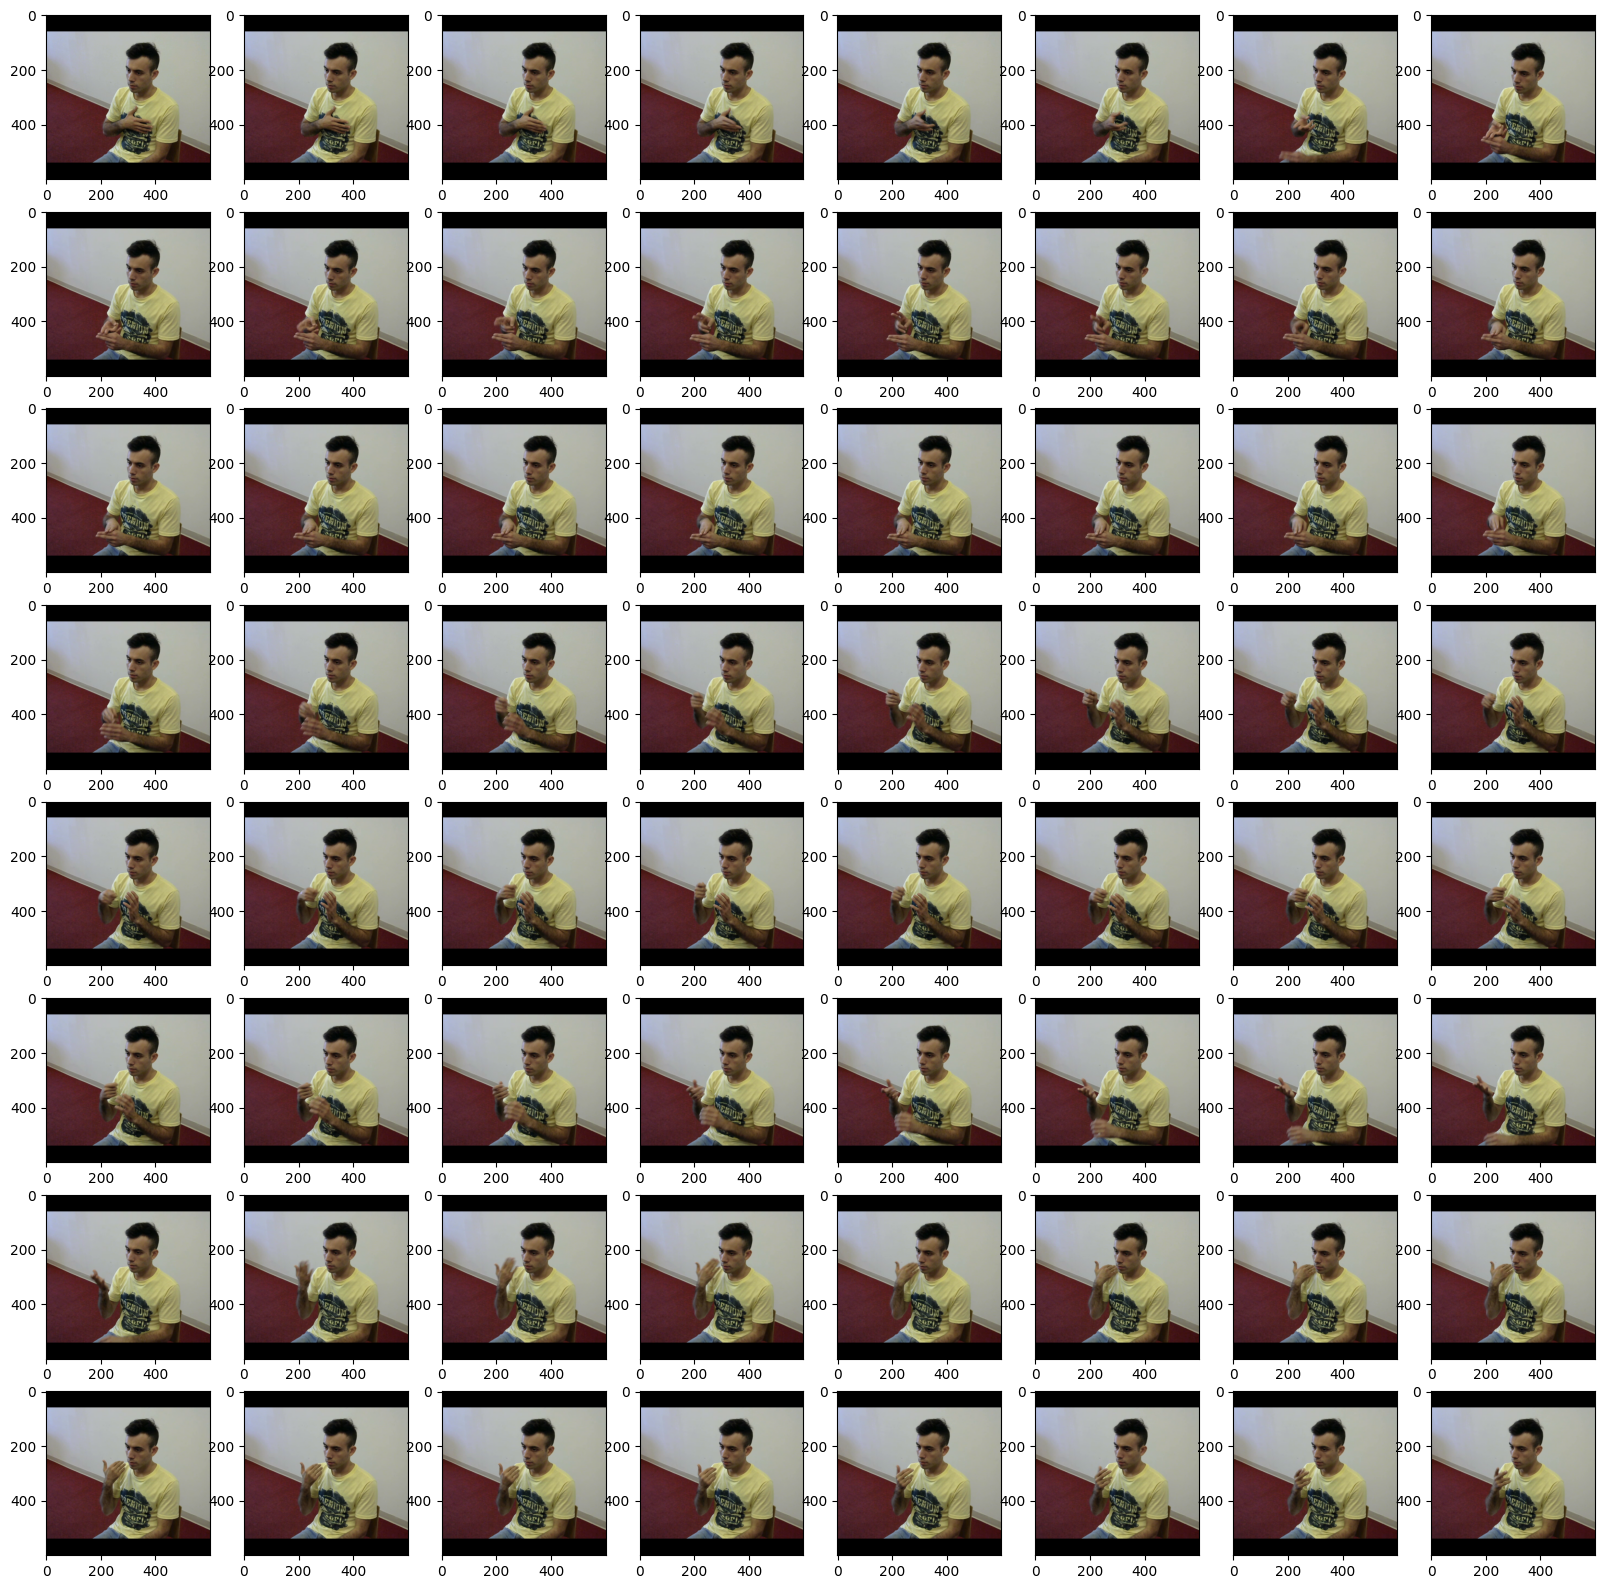

In [31]:
print(a.shape,b.shape,fname)
if config.feature_type == 'no':
  visualize_frames(a)

# No: torch.Size([1, 64, 3, 600, 600]) torch.Size([1, 10, 1]) ('drive/MyDrive/SLR/Data/Video/Cam2/362/2022-12-22 16-32-52.mp4',)
# i3d: torch.Size([1, 5, 2048]) torch.Size([1, 10, 1]) ('/content/drive/MyDrive/SLR/Data/Video/Cam2/315/2022-11-04 14-23-26.mp4',)
# squeezenet: torch.Size([1, 64, 700928]) torch.Size([1, 10, 1]) ('/content/drive/MyDrive/SLR/Data/Video/Cam2/342/2022-12-23 17-17-50.mp4',)